数据集：
股票(30支股票，以天计数)
https://www.kaggle.com/datasets/szrlee/stock-time-series-20050101-to-20171231


based：
https://www.tensorflow.org/tutorials/structured_data/time_series#multi-step_models

In [172]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

数据分析阶段

In [173]:
# 数据集导入
df = pd.read_csv("stock/AABA_2006-01-01_to_2018-01-01.csv")
# df = pd.read_csv("stock/all_stocks_2017-01-01_to_2018-01-01.csv")
df = df.drop(["Name"],axis=1)
df.head()


,Date,Open,High,Low,Close,Volume
0,2006-01-03,39.69,41.22,38.79,40.91,24232729
1,2006-01-04,41.22,41.90,40.77,40.97,20553479
2,2006-01-05,40.93,41.73,40.85,41.53,12829610
3,2006-01-06,42.88,43.57,42.80,43.21,29422828
4,2006-01-09,43.10,43.66,42.82,43.42,16268338


In [174]:
date_time = pd.to_datetime(df.pop('Date'))

In [175]:
df.head()

,Open,High,Low,Close,Volume
0,39.69,41.22,38.79,40.91,24232729
1,41.22,41.90,40.77,40.97,20553479
2,40.93,41.73,40.85,41.53,12829610
3,42.88,43.57,42.80,43.21,29422828
4,43.10,43.66,42.82,43.42,16268338


拆分数据,将对(70%, 20%, 10%)训练、验证和测试集使用拆分

In [176]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
# 训练集，验证集和测试集
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]
# 特征
num_features = df.shape[1]
num_features

5

In [177]:
train_mean = train_df.mean()
train_std = train_df.std()
train_df = (train_df-train_mean)/train_std

In [178]:
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

**数据窗口**


将会构建多种模型（包括linear,DNN,CNN,RNN模型）
1. 单输出和多输出预测
2. 单时间步和多时间步预测

In [179]:
train_df.head()

,Open,High,Low,Close,Volume
0,2.339566,2.477879,2.293832,2.508760,0.002214
1,2.540008,2.566110,2.556679,2.516641,-0.185600
2,2.502016,2.544053,2.567299,2.590190,-0.579878
3,2.757481,2.782795,2.826164,2.810839,0.267151
4,2.786302,2.794473,2.828819,2.838420,-0.404342


定义一个windowGenrator类，实现功能有
1. 如上图所示处理索引和偏移量。
2. 将特征窗口分成(features, labels)对。
3. 绘制结果窗口的内容。
4. tf.data.Dataset使用s.从训练、评估和测试数据中高效地生成这些窗口的批次。

In [180]:
class WindowGenerator():
    def __init__(self,input_width,label_width,shift,train_df=train_df,val_df=val_df,test_df=test_df,label_columns=None):
        '''该__init__方法包括输入和标签索引的所有必要逻辑。
        它还将训练、评估和测试数据帧作为输入。
        这些将在稍后转换为tf.data.Dataset窗口。'''
        self.train_df= train_df
        self.test_df = test_df
        self.val_df = val_df

        self.input_width=input_width
        self.label_width = label_width
        self.shift = shift


        # 定义类别的列
        self.label_columns=label_columns

        if label_columns is not None:
            self.label_columns_indices = {name:i for i,name in enumerate(label_columns)}
        self.columns_indices = {name:i for i,name in enumerate(train_df.columns)}


        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def __repr__(self):
        '''打印数据'''
        return '\n'.join([
            f'Total window size总窗口大小: {self.total_window_size}',
            f'Input indices输入索引: {self.input_indices}',
            f'Label indices标签索引: {self.label_indices}',
            f'Label column name(s)标签列名: {self.label_columns}'])

测试类中的函数

In [181]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['Close'])
w1

Total window size总窗口大小: 48
Input indices输入索引: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices标签索引: [47]
Label column name(s)标签列名: ['Close']

In [182]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['Close'])
w2

Total window size总窗口大小: 7
Input indices输入索引: [0 1 2 3 4 5]
Label indices标签索引: [6]
Label column name(s)标签列名: ['Close']

In [183]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.columns_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [184]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 5)
Inputs shape: (3, 6, 5)
Labels shape: (3, 1, 1)


In [185]:
w2.example = example_inputs, example_labels

In [186]:
def plot(self, model=None, plot_col='Close', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.columns_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [187]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [188]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

----------------------
# 1. single step model
- ​	    baseline
- ​     linear
- ​     dense
- ​     multi-dense
- ​     conv
- ​     rnn
- ​     total
- ​     multi-output models
  
# 2. multi-step model
-  baselines
- single-hot models
- autogress model
- total
  


配置一个WindowGenerator对象以生成这些单步(input, label)对：

In [189]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Close'])
single_step_window

Total window size总窗口大小: 2
Input indices输入索引: [0]
Label indices标签索引: [1]
Label column name(s)标签列名: ['Close']

In [190]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 5)
Labels shape (batch, time, features): (32, 1, 1)


# <u>single-step-model:baseline</u>

<img src ='https://www.tensorflow.org/static/tutorials/structured_data/images/baseline.png'>

In [191]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [192]:
# 以某列的数据为基准
baseline = Baseline(label_index=column_indices['Open'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

19/19 [==============================] - 0s 1ms/step - loss: 0.0154 - mean_absolute_error: 0.0936


In [193]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['Close'])

wide_window

Total window size总窗口大小: 25
Input indices输入索引: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices标签索引: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s)标签列名: ['Close']

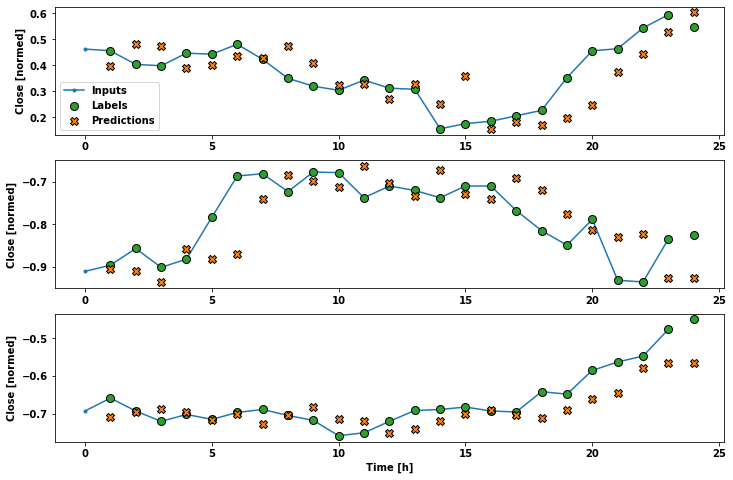

In [194]:
wide_window.plot(baseline)

# <u>single step model :linear</u>


<img src = "https://www.tensorflow.org/static/tutorials/structured_data/images/narrow_window.png">

In [195]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

本教程训练了许多模型，因此将训练过程打包成一个函数：

In [196]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [197]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
66/66 [==============================] - 1s 4ms/step - loss: 0.4499 - mean_absolute_error: 0.5876 - val_loss: 1.5837 - val_mean_absolute_error: 1.1855
Epoch 2/20
66/66 [==============================] - 0s 3ms/step - loss: 0.2031 - mean_absolute_error: 0.3906 - val_loss: 0.6438 - val_mean_absolute_error: 0.7510
Epoch 3/20
66/66 [==============================] - 0s 3ms/step - loss: 0.0810 - mean_absolute_error: 0.2412 - val_loss: 0.2207 - val_mean_absolute_error: 0.4312
Epoch 4/20
66/66 [==============================] - 0s 3ms/step - loss: 0.0304 - mean_absolute_error: 0.1404 - val_loss: 0.0669 - val_mean_absolute_error: 0.2242
Epoch 5/20
66/66 [==============================] - 0s 3ms/step - loss: 0.0132 - mean_absolute_error: 0.0841 - val_loss: 0.0233 - val_mean_absolute_error: 0.1202
Epoch 6/20
66/66 [==============================] - 0s 3ms/step - loss: 0.0086 - mean_absolute_error: 0.0616 - val_loss: 0.0137 - val_mean_absolute_error: 0.0871
Epoch 7/20
66/66 [==========

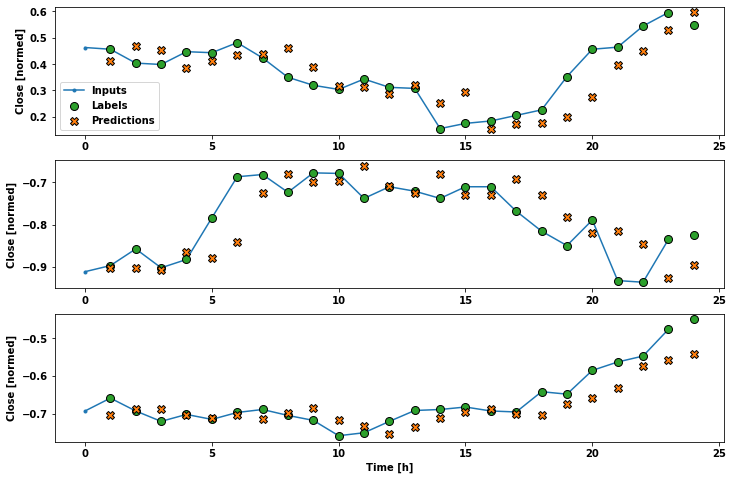

In [198]:
wide_window.plot(linear)

# <u>single-step-model dense</u>


In [199]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
66/66 [==============================] - 1s 5ms/step - loss: 0.1895 - mean_absolute_error: 0.2603 - val_loss: 0.0176 - val_mean_absolute_error: 0.1072
Epoch 2/20
66/66 [==============================] - 0s 3ms/step - loss: 0.0072 - mean_absolute_error: 0.0546 - val_loss: 0.0118 - val_mean_absolute_error: 0.0833
Epoch 3/20
66/66 [==============================] - 0s 3ms/step - loss: 0.0069 - mean_absolute_error: 0.0532 - val_loss: 0.0156 - val_mean_absolute_error: 0.0997
Epoch 4/20
19/19 [==============================] - 0s 2ms/step - loss: 0.0165 - mean_absolute_error: 0.1035


# <u>single-step-model :multi-dense</u>
<img src = "https://www.tensorflow.org/static/tutorials/structured_data/images/conv_window.png">


In [200]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Close'])


In [201]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

19/19 [==============================] - 0s 1ms/step - loss: 0.0160 - mean_absolute_error: 0.0998


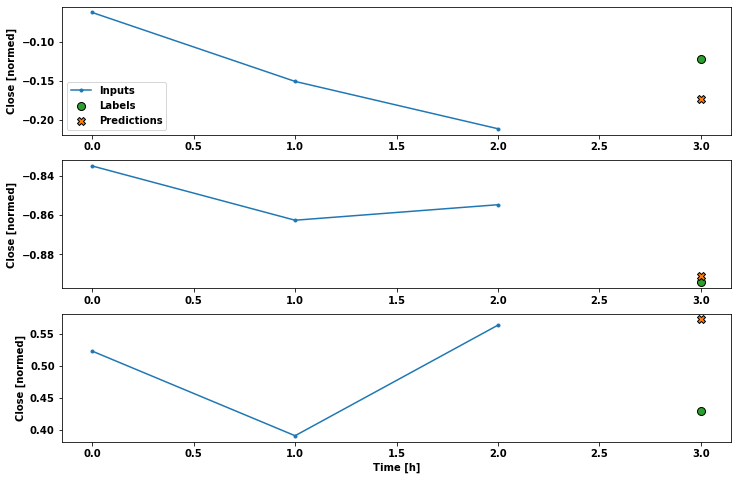

In [202]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)
conv_window.plot(multi_step_dense)

# <u>single-step-model:Multi-step conv</u>
<img src = 'https://www.tensorflow.org/static/tutorials/structured_data/images/wide_conv_window.png'>


In [203]:

conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [204]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

19/19 [==============================] - 0s 1ms/step - loss: 0.0140 - mean_absolute_error: 0.0928


In [205]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Close'])

wide_conv_window

Total window size总窗口大小: 27
Input indices输入索引: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices标签索引: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s)标签列名: ['Close']

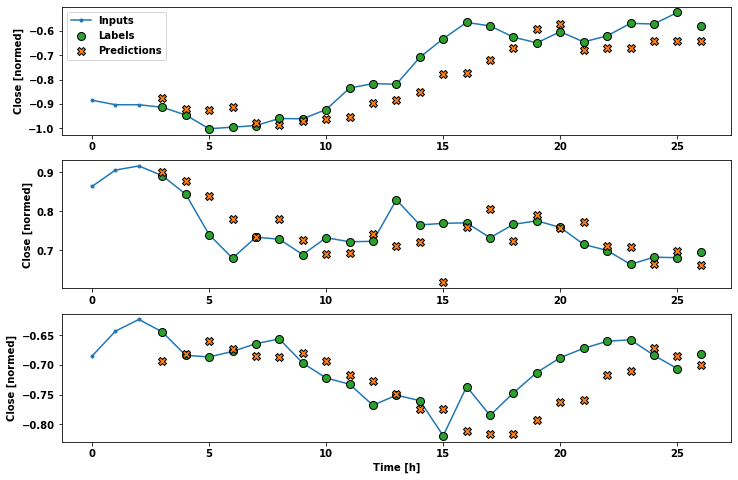

In [206]:
wide_conv_window.plot(conv_model)

# <u>single-step-model: rnn</u>
return_sequences:
false<img src = "https://www.tensorflow.org/static/tutorials/structured_data/images/lstm_1_window.png">


return_sequences :
true<img src = "https://www.tensorflow.org/static/tutorials/structured_data/images/lstm_many_window.png">


In [207]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [208]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

19/19 [==============================] - 0s 3ms/step - loss: 0.0309 - mean_absolute_error: 0.1184


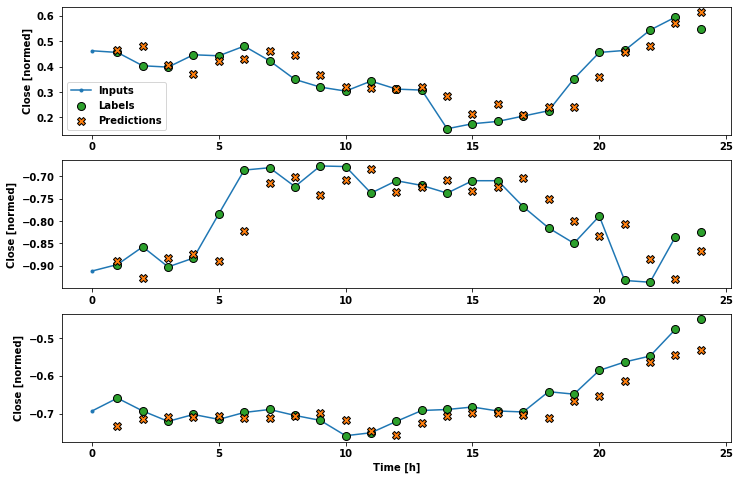

In [209]:
wide_window.plot(lstm_model)

# single-step-model综述

In [210]:
# x = np.arange(len(performance))
# width = 0.3
# metric_name = 'mean_absolute_error'
# metric_index = lstm_model.metrics_names.index('mean_absolute_error')
# val_mae = [v[metric_index] for v in val_performance.values()]
# test_mae = [v[metric_index] for v in performance.values()]

# plt.ylabel('mean_absolute_error [T (degC), normalized]')
# plt.bar(x - 0.17, val_mae, width, label='Validation')
# plt.bar(x + 0.17, test_mae, width, label='Test')
# plt.xticks(ticks=x, labels=performance.keys(),
#            rotation=45)
# _ = plt.legend()

In [211]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0930
Linear      : 0.0873
Dense       : 0.1742
Multi step dense: 0.1548
Conv        : 0.1383
LSTM        : 0.7802
